In [8]:
import pandas as pd
import glob
import os

# Dane statystyczne
urls = [
    "https://www.football-data.co.uk/mmz4281/2324/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2223/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2122/E0.csv",
    "https://www.football-data.co.uk/mmz4281/2021/E0.csv"
]

def load_football_data(url_list):
    # Funkcja ładuje dane z wielu sezonów i łączy je w jeden DataFrame.
    all_seasons = []
    
    for url in url_list:
        try:
            print(f"Pobieranie danych z: {url}")
            # Wczytujemy dane (separator to przecinek w tych plikach)
            df_season = pd.read_csv(url)
            # Dodajemy kolumnę informującą o sezonie (wyciągniętą z URL dla porządku)
            season_label = url.split('/')[-2]
            df_season['Season'] = season_label
            all_seasons.append(df_season)
        except Exception as e:
            print(f"Błąd podczas ładowania {url}: {e}")
            
    # Łączenie wszystkich sezonów w jeden obiekt DataFrame
    full_df = pd.concat(all_seasons, ignore_index=True)
    return full_df

# Wykonanie funkcji
df = load_football_data(urls)

# Wyświetlenie podstawowych informacji o zbiorze
print("\n--- Informacje o załadowanym zbiorze ---")
print(df.info())
print(f"\nRozmiar zbioru: {df.shape}")
print(df.head())

Pobieranie danych z: https://www.football-data.co.uk/mmz4281/2324/E0.csv
Pobieranie danych z: https://www.football-data.co.uk/mmz4281/2223/E0.csv
Pobieranie danych z: https://www.football-data.co.uk/mmz4281/2122/E0.csv
Pobieranie danych z: https://www.football-data.co.uk/mmz4281/2021/E0.csv

--- Informacje o załadowanym zbiorze ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1520 entries, 0 to 1519
Columns: 107 entries, Div to Season
dtypes: float64(82), int64(16), object(9)
memory usage: 1.2+ MB
None

Rozmiar zbioru: (1520, 107)
  Div        Date   Time     HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  \
0  E0  11/08/2023  20:00      Burnley       Man City     0     3   A     0   
1  E0  12/08/2023  12:30      Arsenal  Nott'm Forest     2     1   H     2   
2  E0  12/08/2023  15:00  Bournemouth       West Ham     1     1   D     0   
3  E0  12/08/2023  15:00     Brighton          Luton     4     1   H     1   
4  E0  12/08/2023  15:00      Everton         Fulham     0     1   A

In [9]:
# 1. Wybór istotnych kolumn
# Wyjaśnienie skrótów: FTHG (Gole gospodarzy), FTAG (Gole gości), FTR (Wynik końcowy), 
# HS (Strzały gospodarzy), AS (Strzały gości), HST (Strzały celne gosp.), AST (Strzały celne gości)
cols_to_keep = [
    'Season', 'Date', 'HomeTeam', 'AwayTeam', 'FTHG', 'FTAG', 'FTR', 
    'HTHG', 'HTAG', 'HTR', 'HS', 'AS', 'HST', 'AST', 'HF', 'AF', 
    'HC', 'AC', 'HY', 'AY', 'HR', 'AR'
]

# Tworzymy oczyszczony DataFrame
df_clean = df[cols_to_keep].copy()

# 2. Konwersja daty - bardzo ważne dla analizy szeregów czasowych
# Próbujemy różnych formatów, bo pliki z różnych lat mogą się różnić
df_clean['Date'] = pd.to_datetime(df_clean['Date'], dayfirst=True, errors='coerce')

# 3. Obsługa braków danych
# Sprawdzamy ile mamy braków
print("Liczba brakujących wartości w kolumnach:")
print(df_clean.isnull().sum())

# Usuwamy wiersze, które nie mają daty lub wyniku (jeśli takie są)
df_clean = df_clean.dropna(subset=['Date', 'FTR'])

# 4. Feature Engineering - tworzenie nowych kolumn
# Łączna liczba goli w meczu
df_clean['TotalGoals'] = df_clean['FTHG'] + df_clean['FTAG']

# Czy gospodarz wygrał? (1 - tak, 0 - nie)
df_clean['HomeWin'] = (df_clean['FTR'] == 'H').astype(int)

print("\n--- Dane po obróbce ---")
print(df_clean.head())

Liczba brakujących wartości w kolumnach:
Season      0
Date        0
HomeTeam    0
AwayTeam    0
FTHG        0
FTAG        0
FTR         0
HTHG        0
HTAG        0
HTR         0
HS          0
AS          0
HST         0
AST         0
HF          0
AF          0
HC          0
AC          0
HY          0
AY          0
HR          0
AR          0
dtype: int64

--- Dane po obróbce ---
  Season       Date     HomeTeam       AwayTeam  FTHG  FTAG FTR  HTHG  HTAG  \
0   2324 2023-08-11      Burnley       Man City     0     3   A     0     2   
1   2324 2023-08-12      Arsenal  Nott'm Forest     2     1   H     2     0   
2   2324 2023-08-12  Bournemouth       West Ham     1     1   D     0     0   
3   2324 2023-08-12     Brighton          Luton     4     1   H     1     0   
4   2324 2023-08-12      Everton         Fulham     0     1   A     0     0   

  HTR  ...  HF  AF  HC  AC  HY  AY  HR  AR  TotalGoals  HomeWin  
0   A  ...  11   8   6   5   0   0   1   0           3        0  
1   H 

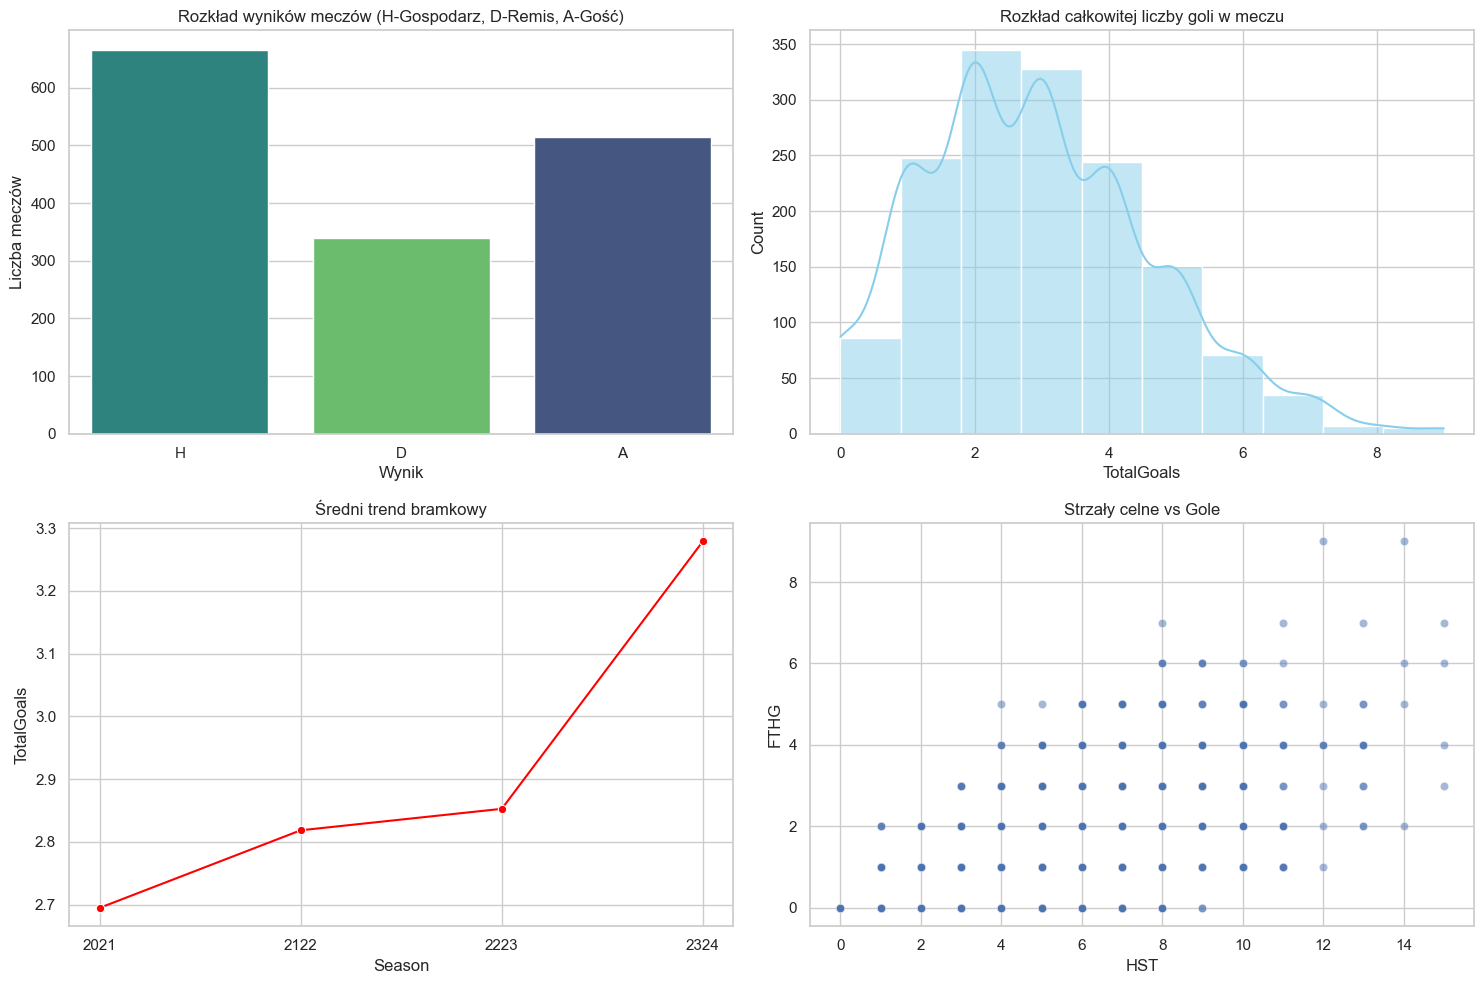

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))

# WYKRES 1: Rozkład wyników (Poprawiony o 'hue' i 'legend')
plt.subplot(2, 2, 1)
sns.countplot(x='FTR', data=df_clean, hue='FTR', palette='viridis', order=['H', 'D', 'A'], legend=False)
plt.title('Rozkład wyników meczów (H-Gospodarz, D-Remis, A-Gość)')
plt.xlabel('Wynik')
plt.ylabel('Liczba meczów')

# WYKRES 2: Rozkład goli
plt.subplot(2, 2, 2)
sns.histplot(df_clean['TotalGoals'], kde=True, bins=10, color='skyblue')
plt.title('Rozkład całkowitej liczby goli w meczu')

# WYKRES 3: Średnia liczba goli na sezon
plt.subplot(2, 2, 3)
season_goals = df_clean.groupby('Season')['TotalGoals'].mean().reset_index()
sns.lineplot(x='Season', y='TotalGoals', data=season_goals, marker='o', color='red')
plt.title('Średni trend bramkowy')

# WYKRES 4: Korelacja
plt.subplot(2, 2, 4)
sns.scatterplot(x='HST', y='FTHG', data=df_clean, alpha=0.5)
plt.title('Strzały celne vs Gole')

plt.tight_layout()
plt.show()

Podstawowe statystyki opisowe:
              FTHG         FTAG          HST          AST   TotalGoals
count  1520.000000  1520.000000  1520.000000  1520.000000  1520.000000
mean      1.575000     1.336184     4.892105     4.138158     2.911184
std       1.367219     1.247304     2.666979     2.411977     1.721377
min       0.000000     0.000000     0.000000     0.000000     0.000000
25%       1.000000     0.000000     3.000000     2.000000     2.000000
50%       1.000000     1.000000     5.000000     4.000000     3.000000
75%       2.000000     2.000000     6.000000     6.000000     4.000000
max       9.000000     8.000000    15.000000    15.000000     9.000000

--- Test t-Studenta (Gole Gospodarzy vs Gości) ---
Statystyka t: 5.0310
Wartość p: 0.0000
Wniosek: Odrzucamy hipotezę zerową. Istnieje statystycznie istotna różnica między liczbą goli strzelanych w domu a na wyjeździe (Atut własnego boiska jest faktem).


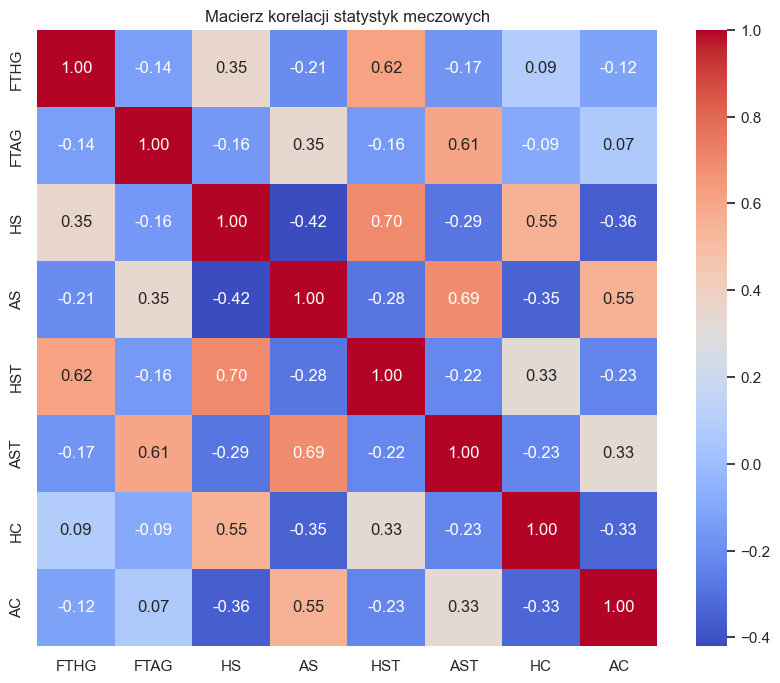

In [11]:
from scipy import stats

# 1. Podstawowe statystyki opisowe dla kluczowych zmiennych
stats_summary = df_clean[['FTHG', 'FTAG', 'HST', 'AST', 'TotalGoals']].describe()
print("Podstawowe statystyki opisowe:")
print(stats_summary)

# 2. Test statystyczny: Test t-Studenta dla prób niezależnych
# Hipoteza H0: Średnia liczba goli strzelanych przez gospodarzy jest taka sama jak przez gości.
# Hipoteza H1: Średnia liczba goli gospodarzy jest różna (wyższa) od gości.

t_stat, p_val = stats.ttest_ind(df_clean['FTHG'], df_clean['FTAG'])

print(f"\n--- Test t-Studenta (Gole Gospodarzy vs Gości) ---")
print(f"Statystyka t: {t_stat:.4f}")
print(f"Wartość p: {p_val:.4f}")

if p_val < 0.05:
    print("Wniosek: Odrzucamy hipotezę zerową. Istnieje statystycznie istotna różnica między liczbą goli strzelanych w domu a na wyjeździe (Atut własnego boiska jest faktem).")
else:
    print("Wniosek: Brak podstaw do odrzucenia hipotezy zerowej.")

# 3. Analiza korelacji (Heatmap)
plt.figure(figsize=(10, 8))
correlation_matrix = df_clean[['FTHG', 'FTAG', 'HS', 'AS', 'HST', 'AST', 'HC', 'AC']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Macierz korelacji statystyk meczowych")
plt.show()

In [12]:
# To jest opcjonalne - uruchom jeśli masz zainstalowanego Sparka
# try:
from pyspark.sql import SparkSession
    
# Inicjalizacja sesji Spark
spark = SparkSession.builder.appName("FootballAnalysis").get_OrCreate()
    
# Konwersja Pandas DF do Spark DF
spark_df = spark.createDataFrame(df_clean.astype(str)) 
    
    # Przykładowa operacja Big Data: Średnia liczba goli na drużynę
spark_df.createOrReplaceTempView("matches")
result = spark.sql("""
        SELECT HomeTeam, AVG(CAST(FTHG AS FLOAT)) as AvgHomeGoals 
        FROM matches 
        GROUP BY HomeTeam 
        ORDER BY AvgHomeGoals DESC
""")
result.show(10)


ModuleNotFoundError: No module named 'pyspark'